In [1]:
import numpy as np
import geometry
from matplotlib import pyplot as plt
from scipy.special import p_roots
from scipy.sparse.linalg import gmres

In [41]:
points = np.array([[-1,  -1] , [1,  -1], [1,   1], [-1,   1]])
gamma1 = geometry.line(points[0], points[1],n=100)
u1 = np.zeros(gamma1.x.shape)
v1 = np.zeros(gamma1.x.shape)
gamma2 = geometry.cap(rotate=-np.pi/2, shift=(points[1]+points[2])/2, scale=(1,3), n=100)
u2 = 1 - gamma2.y**2
v2 = np.zeros(gamma2.x.shape)
gamma3 = geometry.line(points[2], points[3],n=100)
u3 = np.zeros(gamma3.x.shape)
v3 = np.zeros(gamma3.x.shape)
gamma4 = geometry.cap(rotate=np.pi/2, shift=(points[3]+points[0])/2, scale=(1,3), n=100)
u4 = 1 - gamma4.y**2
v4 = np.zeros(gamma4.x.shape)
Gamma = [ gamma1, gamma2, gamma3, gamma4 ]
Gamma = [gamma.get_data() for gamma in Gamma]

a = np.concatenate(
    [gamma[0] + 2*i for i, gamma in zip(range(len(Gamma)), Gamma)])
da = np.concatenate([gamma[1] for gamma in Gamma])
t = np.concatenate([gamma[2] for gamma in Gamma])
dt_da = np.concatenate([gamma[3] for gamma in Gamma])
k = np.concatenate([gamma[4] for gamma in Gamma])
u = np.concatenate([u1, u2, u3, u4])
v = np.concatenate([v1, v2, v3, v4])

h2 = u
h1 = -v

In [42]:
k[k<0] = 0

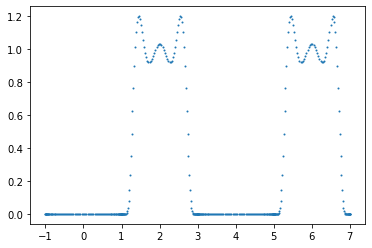

In [43]:
# plt.scatter(a,t.real,s=1)
# plt.scatter(a,t.imag,s=1)
plt.scatter(a,k,s=1, label='curvature')
# plt.scatter(a,(dt_da*da).real,s=1)
# plt.scatter(a,(dt_da*da).imag,s=1)

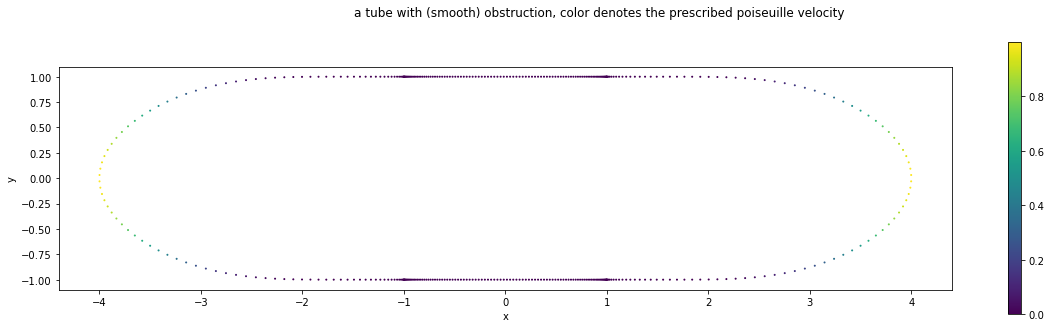

In [46]:
fig,ax = plt.subplots(figsize=(20,5))
cm = ax.scatter(t.real,t.imag, c=u,s=1)
ax.set_aspect('equal')
fig.colorbar(cm)
fig.suptitle('a tube with (smooth) obstruction, color denotes the prescribed poiseuille velocity')
ax.set_xlabel('x')
ax.set_ylabel('y')
print()

## solving the flow

In [67]:
def signed_kernels(t, dt_da, da, curvature):
    dt = t[:, np.newaxis] - t[np.newaxis, :]
    d = dt_da[np.newaxis, :]

    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore', invalid='ignore'):
        K1 = - (d/dt).imag / np.pi 
        K2 = (d/np.conjugate(dt) - np.conjugate(d)*dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = curvature*np.abs(d)/(2*np.pi)
    K2_diagonal = -curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1, K1_diagonal)
    np.fill_diagonal(K2, K2_diagonal)
    # multiply by da
    K1 = K1*(da[np.newaxis, :])
    K2 = K2*(da[np.newaxis, :])
    return K1, K2

def kernels(t,dt_da,h,curvature):
    dt = t[:,np.newaxis] - t[np.newaxis,:]
    d = dt_da[np.newaxis,:]
    hh = h[np.newaxis,:]
    
    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore',invalid='ignore'):
        K1 = -hh * np.imag(d/dt) / np.pi
        K2 = -hh * (-d/np.conjugate(dt) + np.conjugate(d)*dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = curvature*np.abs(d)*h/(2*np.pi)
    K2_diagonal = -h*curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1,K1_diagonal)
    np.fill_diagonal(K2,K2_diagonal)
    
    return K1,K2

In [72]:
K1, K2 = kernels(t, dt_da, da, k)

In [73]:
n = len(t)

In [74]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real
rhs = np.concatenate((h1,h2))
x0 = np.concatenate((np.zeros(n), 1- t.imag**2))

In [75]:
omega, _ = gmres(A, rhs, x0=x0, tol=1e-12)
if _ == 0:
    print('gmres converged')
else:
    print('gmres did not converge')

omega = omega[:n] + 1j*omega[n:]

gmres converged


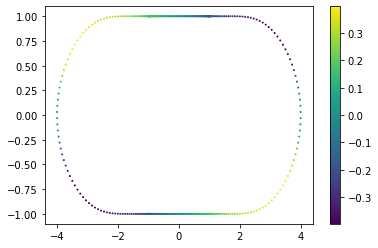

In [77]:
plt.scatter(t.real,t.imag,c=omega.real ,s=1)
plt.colorbar()

In [78]:
def evaluation(z,omega,t,da,dt_da):
    
    d_t = dt_da*da
    t_minus_z = t-z
    t_minus_z_square = t_minus_z**2
    
    phi = np.sum(omega*d_t/t_minus_z)/(2j*np.pi)
    d_phi = np.sum(omega*d_t/(t_minus_z**2))/(2j*np.pi)
    
    psi = (1/(2j*np.pi))*(
        2*np.sum(np.real(np.conjugate(omega)*d_t)/t_minus_z)
        - np.sum(np.conjugate(t)*omega*d_t/t_minus_z_square))
    
    dW = phi + z*np.conjugate(d_phi) + np.conjugate(psi)
    
    return dW


In [79]:
grid = np.array([(x,y) for x in np.linspace(-2,2,200) for y in np.linspace(-0.5,0.5,100)])
grid_x, grid_y = np.array(grid).T
grid_z = grid_x + 1j*grid_y
grid_val = np.array([evaluation(z,omega,t,da,dt_da) for z in grid_z])
poiseuille_val = 1j*np.array([1-y**2 for x,y in grid])

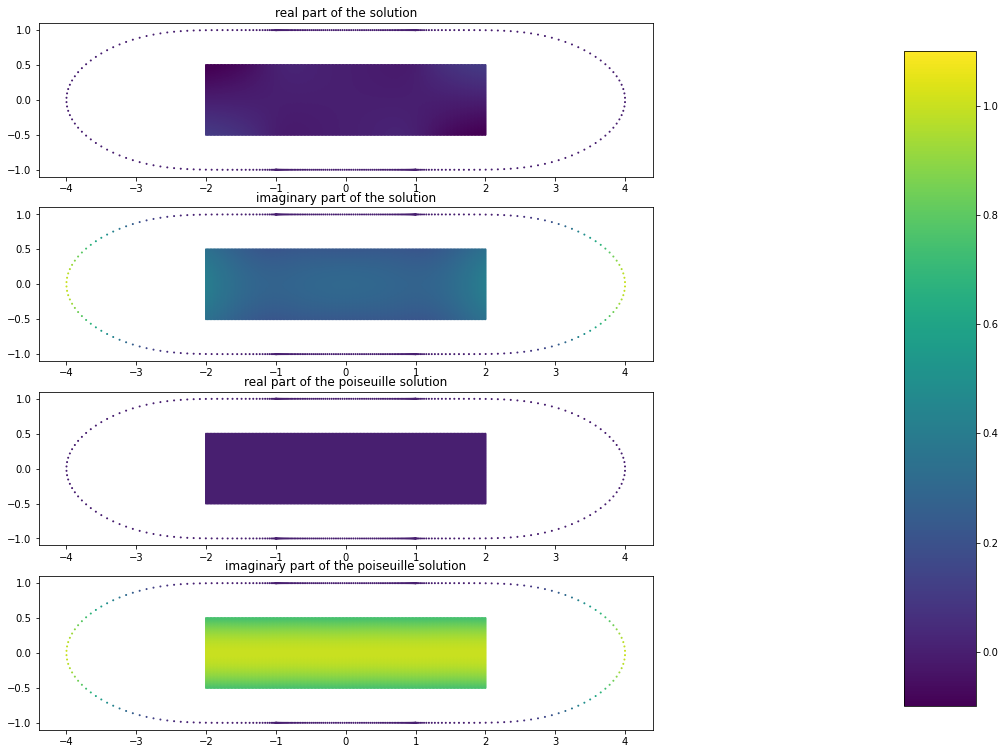

In [80]:
fig, axes = plt.subplots(4,1,figsize=(20,13))

vmin = -0.1
vmax = 1.1

axes[0].set_title('real part of the solution')
axes[0].scatter(t.real,t.imag,c=h1 ,s=1,vmin=vmin,vmax=vmax)
axes[0].scatter(grid_x,grid_y,c=grid_val.real,s=1,vmin=vmin,vmax=vmax)
axes[0].set_aspect('equal')

axes[1].set_title('imaginary part of the solution')
axes[1].scatter(t.real,t.imag, c=h2,s=1,vmin=vmin,vmax=vmax)
axes[1].scatter(grid_x,grid_y,c=grid_val.imag,s=1,vmin=vmin,vmax=vmax)
axes[1].set_aspect('equal')

axes[2].set_title('real part of the poiseuille solution')
axes[2].scatter(t.real,t.imag, c=h1,s=1,vmin=vmin,vmax=vmax)
axes[2].scatter(grid_x,grid_y,c=poiseuille_val.real,s=1,vmin=vmin,vmax=vmax)
axes[2].set_aspect('equal')

axes[3].set_title('imaginary part of the poiseuille solution')
im = axes[3].scatter(t.real,t.imag, c=h2,s=1,vmin=vmin,vmax=vmax)
axes[3].scatter(grid_x,grid_y,c=poiseuille_val.imag,s=1,vmin=vmin,vmax=vmax)
axes[3].set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


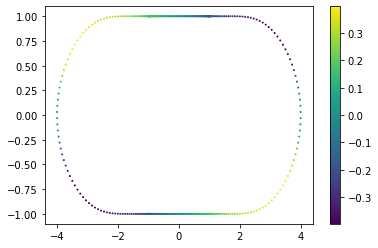

In [81]:
plt.scatter(t.real,t.imag,c=omega.real ,s=1)
plt.colorbar()

this is problematic

The problem must com from the geometry

# investigating the geometry

In [ ]:
a, t, dt_da, da, k,